**VERSÃO BETA ENVOLVENDO AS PRINCIPAIS IDEIAS E OS RECURSOS QUE SERÃO UTILIZADOS NO PROJETO**

Importação das bibliotecas:

In [47]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import random

Caminho para obter as imagens de bois saudáveis e bois com a doença dermatofilose:

OBS: Na etapa atual nós temos um pequeno dataset (20 imagens) que possuí uma pasta para 10 img de bois com dermatofilose e outra pasta para 10 img de bois saudáveis. Com isso vamos utilizar Diretórios futuramente para organizar o conjunto de dados.

In [48]:
# Se quiser testar, pegue as duas imagens que estará na pasta da entrega e faça o upload aqui na pasta do colab e coloque o caminho certo!
healthy_image_path = '/content/boi_6.jpg'
diseased_image_path = '/content/boi_dermatofilose8.jpg'

Função para carregar e fazer o pré-processamento das img:

In [49]:
def load_and_preprocess_image(image_path, label):
    images = []
    labels = []
    img = cv2.imread(image_path)
    if img is not None:
        img_resized = cv2.resize(img, (224, 224))
        gray_image = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
        denoised_image = cv2.fastNlMeansDenoising(gray_image, None, 30, 7, 21)
        sobelx = cv2.Sobel(denoised_image, cv2.CV_64F, 1, 0, ksize=5)
        sobely = cv2.Sobel(denoised_image, cv2.CV_64F, 0, 1, ksize=5)
        sobel_combined = cv2.magnitude(sobelx, sobely)
        edges = cv2.Canny(denoised_image, 100, 200)

        # Armazenar imagens para visualização
        images.append({
            'original': img_resized,
            'gray': gray_image,
            'denoised': denoised_image,
            'details': sobel_combined,
            'edges': edges,
            'array': img_to_array(denoised_image) / 255.0  # Normalização
        })
        labels.append(label)
    return images, labels


Carregamento das img:

In [50]:
healthy_images, healthy_labels = load_and_preprocess_image(healthy_image_path, 0)
diseased_images, diseased_labels = load_and_preprocess_image(diseased_image_path, 1)

Combinação dos dados(img) e conversão para arrays da biblioteca numpy:

In [51]:
all_images = healthy_images + diseased_images
data = np.array([img['array'] for img in all_images])
labels = np.array(healthy_labels + diseased_labels)

Divisão dos dados para treinamento e validação:

In [52]:
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42) #20% para teste

One-hot-enconding para o modelo de classificação:

In [53]:
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)

Construção do modelo de ML utilizando uma rede neural convulucional(CNN):

In [54]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')  # Alterar para softmax para multi-classe (2 classes)
])

Compilação do modelo com o uso da técnica ADAM:

In [55]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Treinando o modelo:

OBS: A acurácia esta ruim pelo fato de ter 2 dados apenas

In [56]:
model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.5902 - accuracy: 1.0000 - val_loss: 116.6783 - val_accuracy: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 1s 939ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 199.8236 - val_accuracy: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 1s 903ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 267.1306 - val_accuracy: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 1s 929ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 324.2708 - val_accuracy: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 1s 927ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 373.9950 - val_accuracy: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 1s 889ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 417.9129 - val_accuracy: 0.0000e+00
Epoch 7/10
1/1 [==============================] - 1s 897ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val

Salvar o modelo treinado:

In [57]:
model.save('agrocare_bovino.h5')

Visualização de amostras de imagens (original, cinza, sem Ruído, realçados e com bordas detectadas):

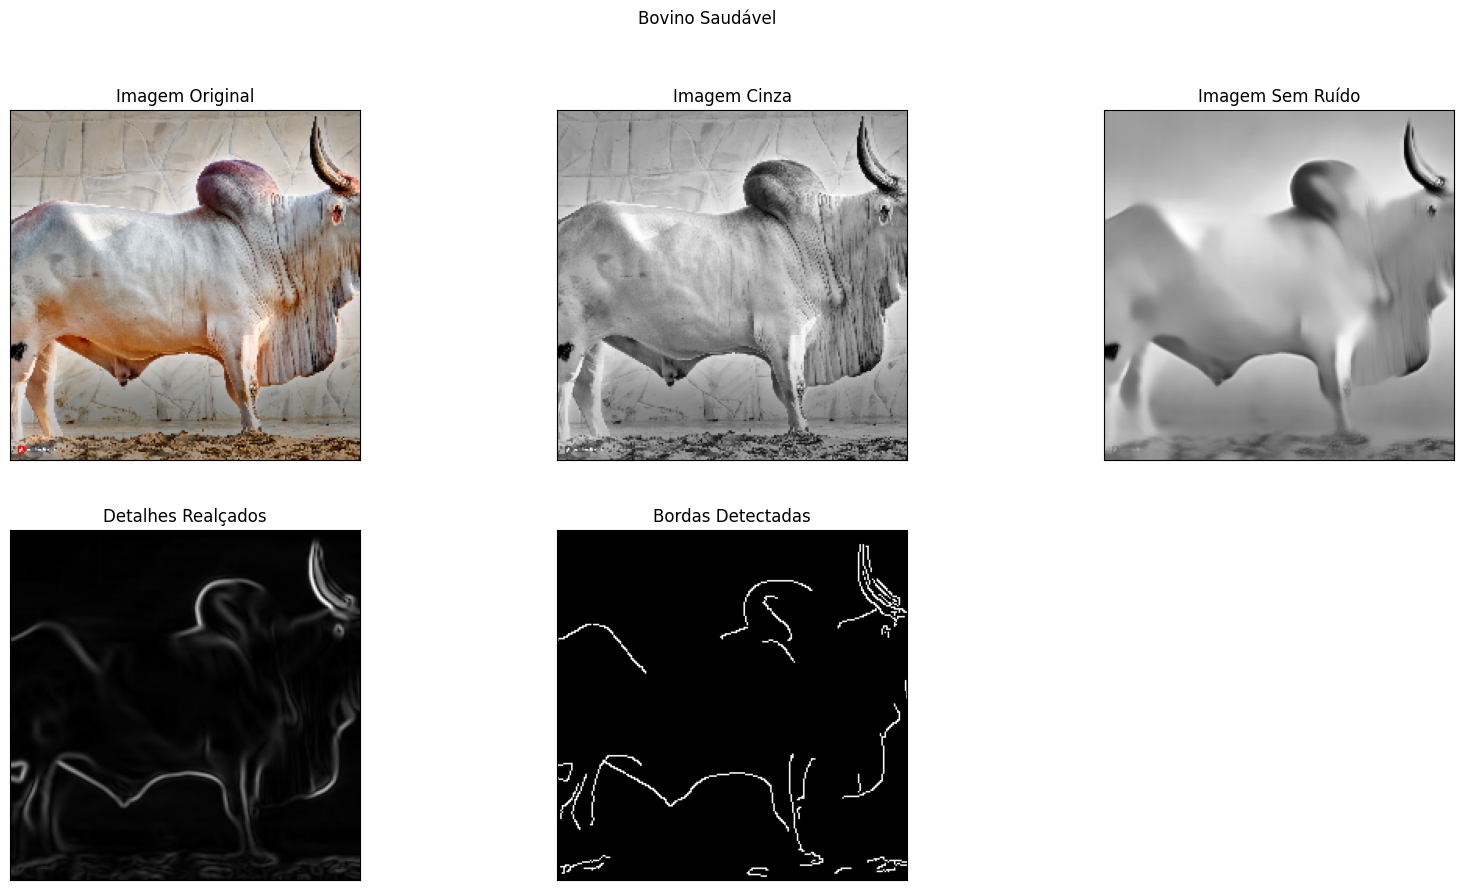

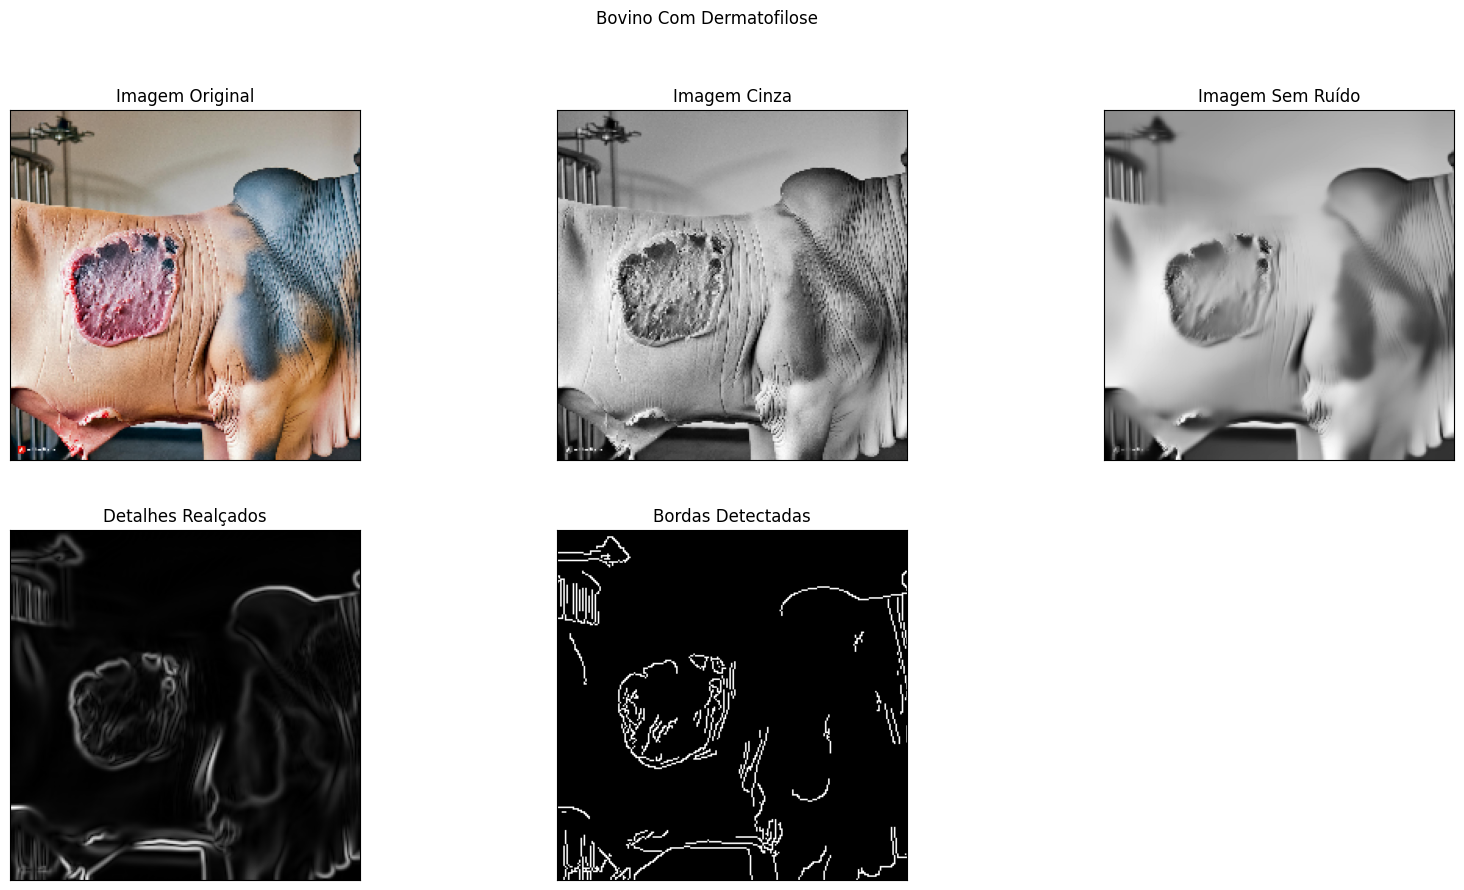

In [58]:
healthy_sample = random.choice(healthy_images)  # Imagem selecionada de maneira aleatória para quando formos utilizar o diretório do conjunto de dados de bois saudáveis
diseased_sample = random.choice(diseased_images)  # Imagem selecionada de maneira aleatória para quando formos utilizar o diretório do conjunto de dados de bois doentes

samples = [healthy_sample, diseased_sample]
sample_titles = ['Saudável', 'Com Dermatofilose']

for index, sample in enumerate(samples):
    titles = ['Imagem Original', 'Imagem Cinza', 'Imagem Sem Ruído', 'Detalhes Realçados', 'Bordas Detectadas']
    images = [sample['original'], sample['gray'], sample['denoised'], sample['details'], sample['edges']]

    plt.figure(figsize=(20, 10))
    plt.suptitle(f'Bovino {sample_titles[index]}')

    for i in range(5):
        plt.subplot(2, 3, i+1)
        if i == 0:
            plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(images[i], 'gray')
        plt.title(titles[i])
        plt.xticks([]), plt.yticks([])

    plt.show()
